In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipykernel_3160/2011421623.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pip install librosa pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Ajuster les options d'affichage
pd.set_option('display.max_columns', None)  # Aucune limite sur le nombre de colonnes affichées
pd.set_option('display.max_colwidth', None)  # Aucune limite sur la largeur du contenu de la colonne

In [4]:
!pwd

/root/3A/ProjetLong/OrthopteraStridulationClassifier/Notebooks/XgBoost


In [5]:
%cd ../../../

/root/3A/ProjetLong


In [6]:
# Correctly specifying your file path
# path_global_5s_train = "drive/MyDrive/Dataset5sec/CSVs morceaux audio 5s/Audible/train_audible_recording_chunks.csv"
# path_global_5s_test = "drive/MyDrive/Dataset5sec/CSVs morceaux audio 5s/Audible/test_audible_recording_chunks.csv"
# path_global_5s_val = "drive/MyDrive/Dataset5sec/CSVs morceaux audio 5s/Audible/val_audible_recording_chunks.csv"

# path_global_5s_train = "DataSet/CSVs_morceaux_audio_5s/Audible/train_audible_recording_chunks.csv"
# path_global_5s_test = "DataSet/CSVs_morceaux_audio_5s/Audible/test_audible_recording_chunks.csv"
# path_global_5s_val = "DataSet/CSVs_morceaux_audio_5s/Audible/val_audible_recording_chunks.csv"

path_global_5s_train = "DataSet/NewDataSet5sec/train_audible_recording_chunks.csv"
path_global_5s_test = "DataSet/NewDataSet5sec/test_audible_recording_chunks.csv"
path_global_5s_val = "DataSet/NewDataSet5sec/val_audible_recording_chunks.csv"

# Using pandas to read the CSV file into a DataFrame
df_train = pd.read_csv(path_global_5s_train)
df_test = pd.read_csv(path_global_5s_test)
df_val = pd.read_csv(path_global_5s_val)

# df filtered for order 
df_train_order = df_train[df_train["label_class"] == "Insecta"]
df_test_order = df_test[df_test["label_class"] == "Insecta"]
df_val_order = df_val[df_val["label_class"] == "Insecta"]

/tmp/ipykernel_3160/978523696.py:15: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(path_global_5s_train)


In [7]:
from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# label_encoder.fit(df_train['label'])

label_encoder_category = LabelEncoder()
label_encoder_category.fit(df_train['label_category'])

label_encoder_soundtype = LabelEncoder()
label_encoder_soundtype.fit(df_train['sound_type'])

label_encoder_order = LabelEncoder()
label_encoder_order.fit(df_train_order['label_order'])

def clean_data(df, df_order):
    y = df['label']
    y_category = df['label_category']
    y_soundtype = df['sound_type']
    # y_kingdom = df['label_kingdom']
    # y_class = df['label_class']
    y_order = df_order['label_order']
    # y_family = df['label_family']
    # y_subfamily = df['label_subfamily']

    # Convertir les étiquettes en nombres
    # y_label_encoded = label_encoder.transform(y)
    y_category_encoded = label_encoder_category.transform(y_category)
    y_soundtype_encoded = label_encoder_soundtype.transform(y_soundtype)
    y_order_encoded = label_encoder_order.transform(y_order)

    """df = df.drop(['label', 'recording_chunk_id', 'recording_id', 'annotation_chunk_id',
                  'sound_type', 'label_category', 'label_kingdom', 'label_class',
                  'label_order', 'label_family', 'label_subfamily', 'confidence_level',
                  'vocalization_type', 'code_n_ind', 'annotation_duration_prior_to_split',
                  'code_unique', 'categorie', 'ordre', 'espece', 'auteur', 'operateur',
                  'avis_operateur', 'validateur', 'espece_validee', 'permis_utilisation',
                  'date', 'GPS', 'nb_chanteurs', 'autres_especes_nb', 'autres_especes_annotees',
                  'bruits_anthropiques', 'bruits_geophoniques', 'bruit_de_fond', 'enregistreur',
                  'micro', 'bonnette', 'expansion_de_temps', 'localisation', 'annotation',
                  'annotation_exhaustive', 'photo', 'stereo', 'notes', 'annotation_initial_time',
                  'annotation_final_time', 'chunk_initial_time', 'chunk_final_time', 'sampling_rate',
                  'BPS'], axis=1)

    df = df.select_dtypes(['number'])"""
    
    df['duree'] = df['duree_min'] * 60 + df['duree_sec']
    df = df[['max_frequency', 'min_frequency', 'avg_frequency', 'duree']]
    df['min_frequency'] = df['min_frequency'].astype(int)
    df['max_frequency'] = df['max_frequency'].astype(int)

    # Gestion des valeurs manquantes
    #df.fillna(df.mean(), inplace=True)
    df = df.dropna()

    # Gestion des variables catégorielles
    df = pd.get_dummies(df)

    X = df

    # For the order label
    df_order['duree'] = df_order['duree_min'] * 60 + df_order['duree_sec']
    df_order = df_order[['max_frequency', 'min_frequency', 'avg_frequency', 'duree']]
    df_order['min_frequency'] = df_order['min_frequency'].astype(int)
    df_order['max_frequency'] = df_order['max_frequency'].astype(int)

    # Gestion des valeurs manquantes
    #df.fillna(df.mean(), inplace=True)
    df_order = df_order.dropna()

    # Gestion des variables catégorielles
    df_order = pd.get_dummies(df_order)

    X_order = df_order


    return X, y_soundtype_encoded, y_category_encoded, y_order_encoded, X_order

X_train, y_train_soundtype, y_train_category, y_train_order, X_train_order = clean_data(df_train, df_train_order)
X_test, y_test_soundtype, y_test_category, y_test_order, X_test_order = clean_data(df_test, df_test_order)
X_val, y_val_soundtype, y_val_category, y_val_order, X_val_order = clean_data(df_val,df_val_order)

/tmp/ipykernel_3160/2076723695.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['min_frequency'] = df['min_frequency'].astype(int)
/tmp/ipykernel_3160/2076723695.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['max_frequency'] = df['max_frequency'].astype(int)
/tmp/ipykernel_3160/2076723695.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [9]:
# # Random forest


# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

# rf_classifier.fit(X_train, y_train_label)

# predictions_label = rf_classifier.predict(X_test)

# # Évaluation LightGBM
# print("Évaluation LightGBM :")
# print("Accuracy sur l'ensemble de validation:", accuracy_score(y_test_label, predictions_label))
# print(classification_report(y_test_label, predictions_label))

# # matrice de confusion
# cm = confusion_matrix(y_test_label, predictions_label)
# y_test_inversed = label_encoder.inverse_transform(y_test_label)

# unique_labels = np.unique(y_test_inversed)

# plt.figure(figsize=(30,30))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
# plt.title('Matrice de confusion - Labels')
# plt.ylabel('Valeur réelle')
# plt.xlabel('Valeur prédite')
# plt.show()

Évaluation LightGBM :
Accuracy sur l'ensemble de validation: 0.8078005629272216
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       336
           1       0.72      0.88      0.79        58
           2       0.52      0.74      0.61       112
           3       0.27      0.14      0.18        86
           4       0.37      0.28      0.32        71
           5       0.55      0.32      0.40       106
           6       0.00      0.00      0.00        22
           7       0.48      0.22      0.30        54
           8       0.95      0.94      0.95      1642

    accuracy                           0.81      2487
   macro avg       0.49      0.47      0.47      2487
weighted avg       0.80      0.81      0.80      2487



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


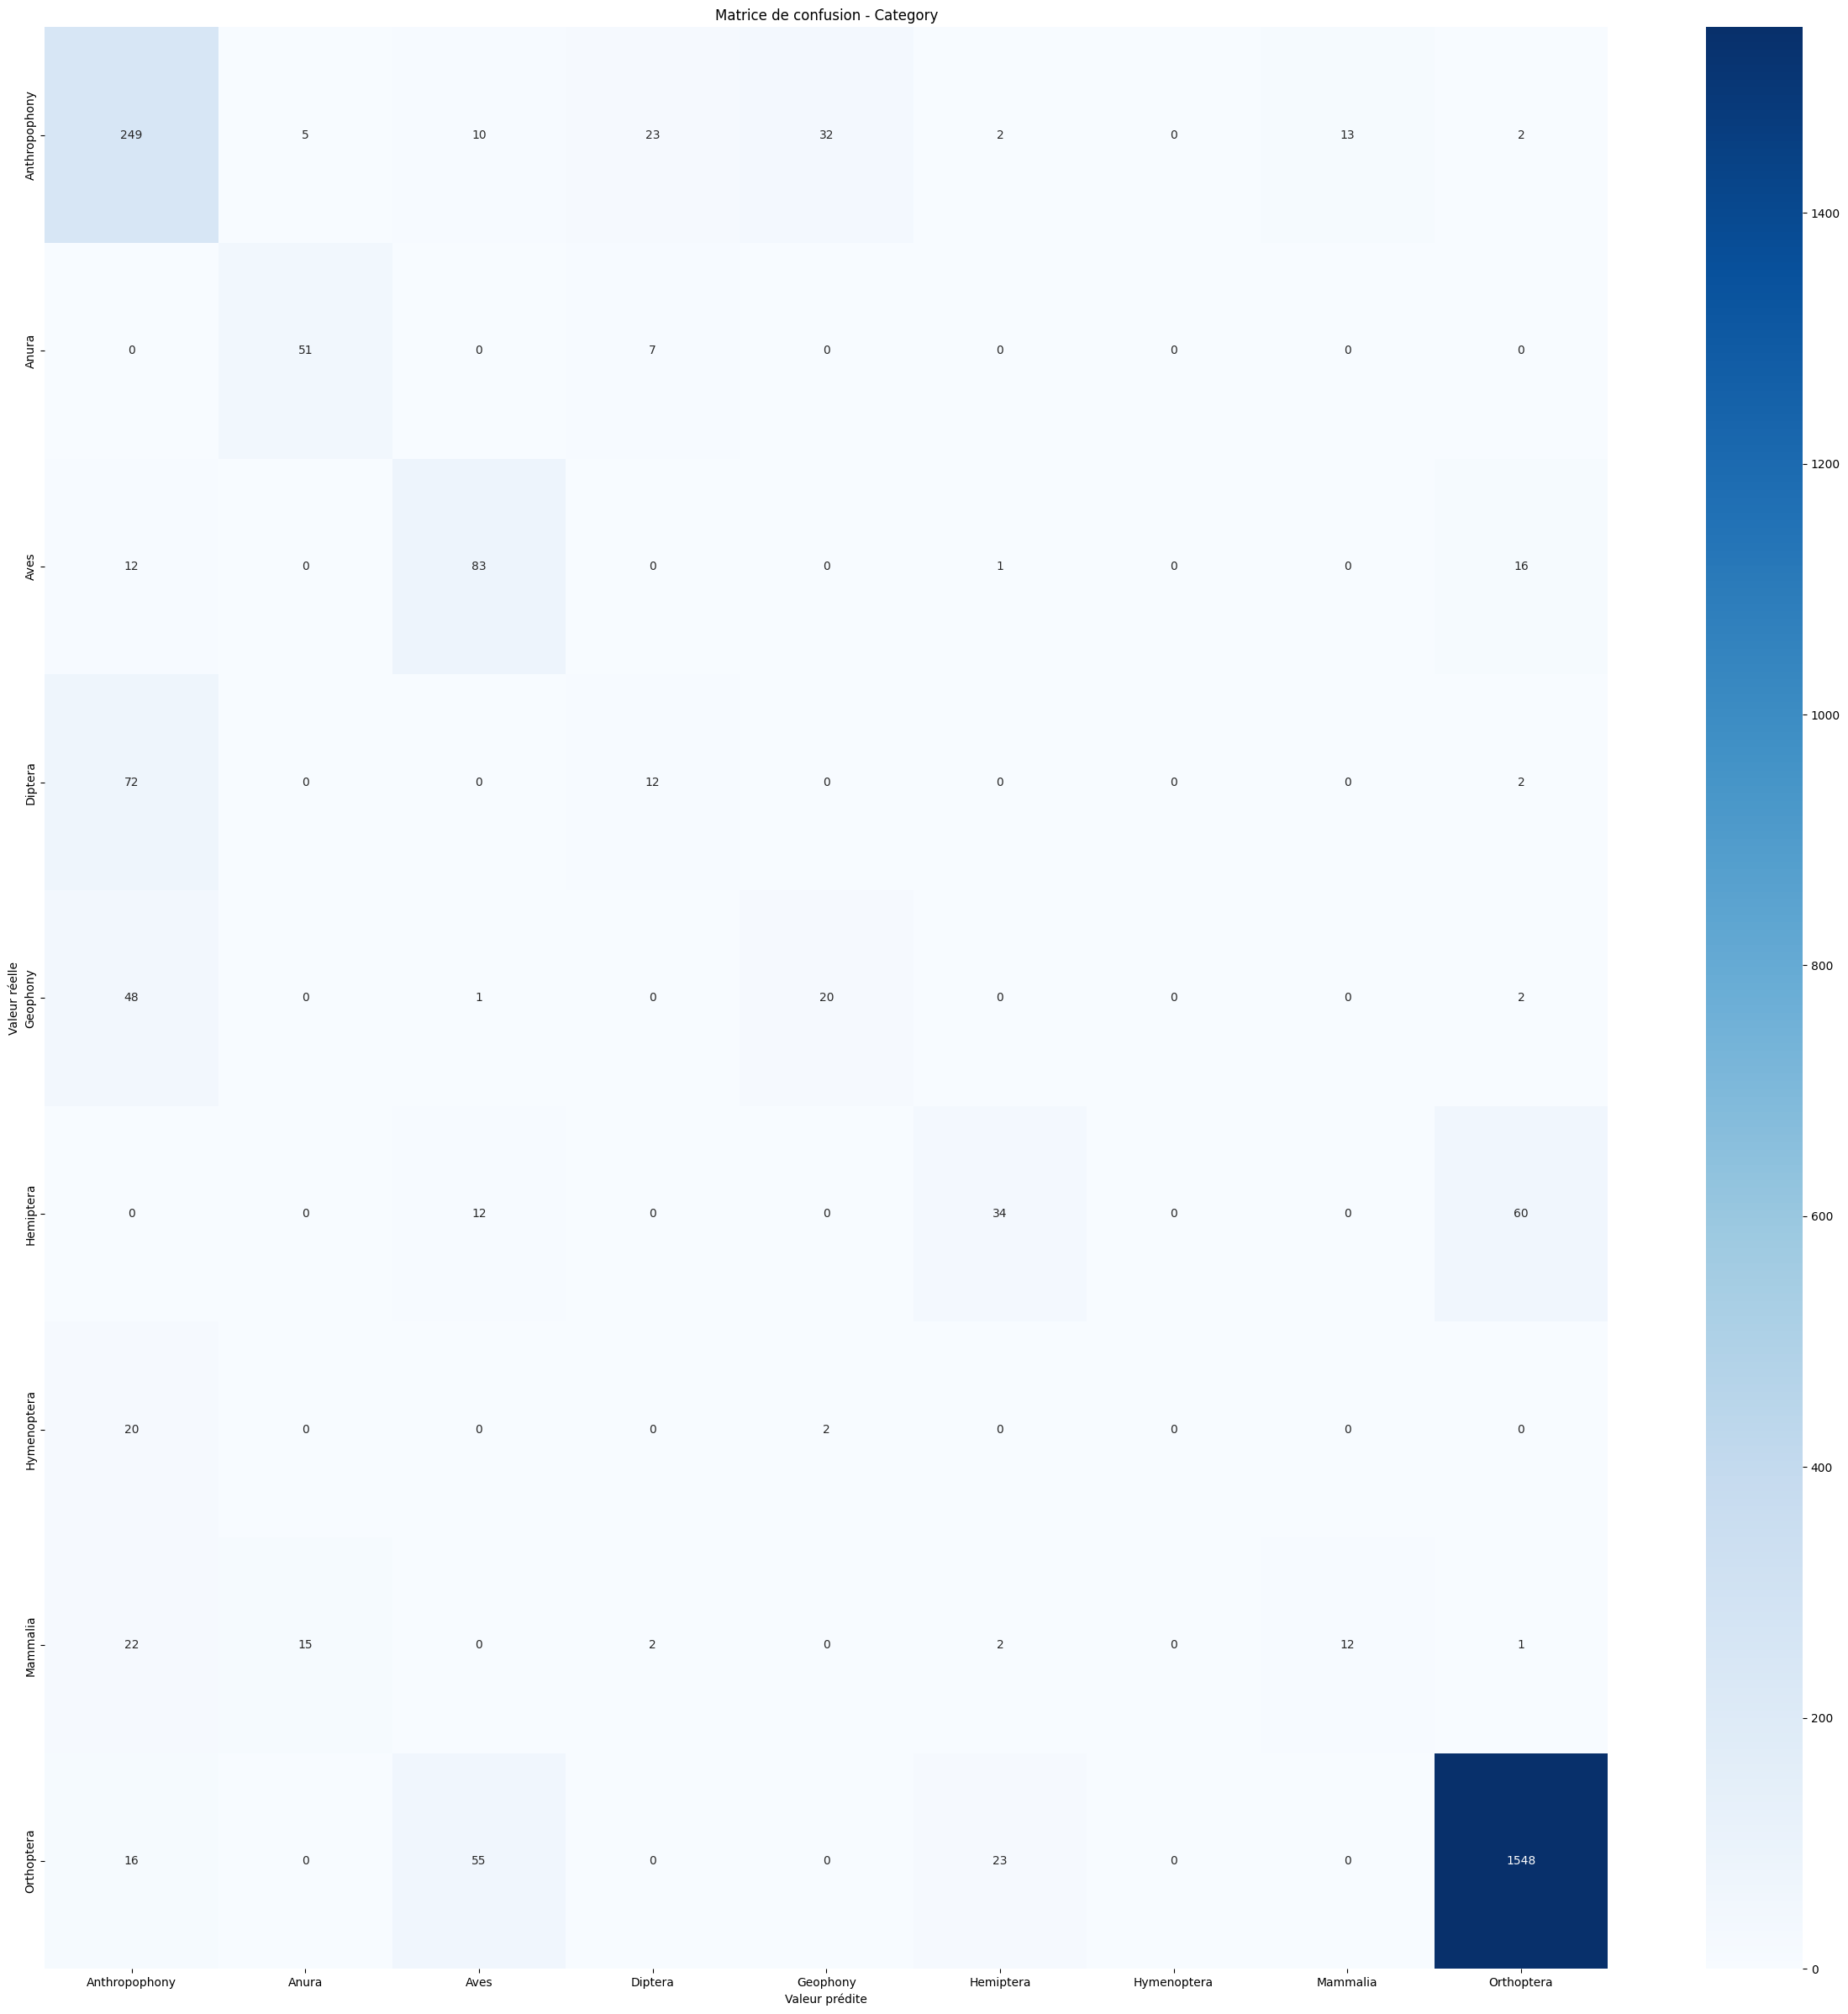

In [10]:
rf_classifier_category = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

rf_classifier_category.fit(X_train, y_train_category)

predictions_category = rf_classifier_category.predict(X_test)

# Évaluation LightGBM
print("Évaluation LightGBM :")
print("Accuracy sur l'ensemble de validation:", accuracy_score(y_test_category, predictions_category))
print(classification_report(y_test_category, predictions_category))

# matrice de confusion
cm = confusion_matrix(y_test_category, predictions_category)
y_test_inversed = label_encoder_category.inverse_transform(y_test_category)

unique_labels = np.unique(y_test_inversed)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion - Category')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()

Évaluation LightGBM :
Accuracy sur l'ensemble de validation: 0.9493365500603136
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1992
           2       0.85      0.91      0.88       495

    accuracy                           0.95      2487
   macro avg       0.91      0.93      0.92      2487
weighted avg       0.95      0.95      0.95      2487



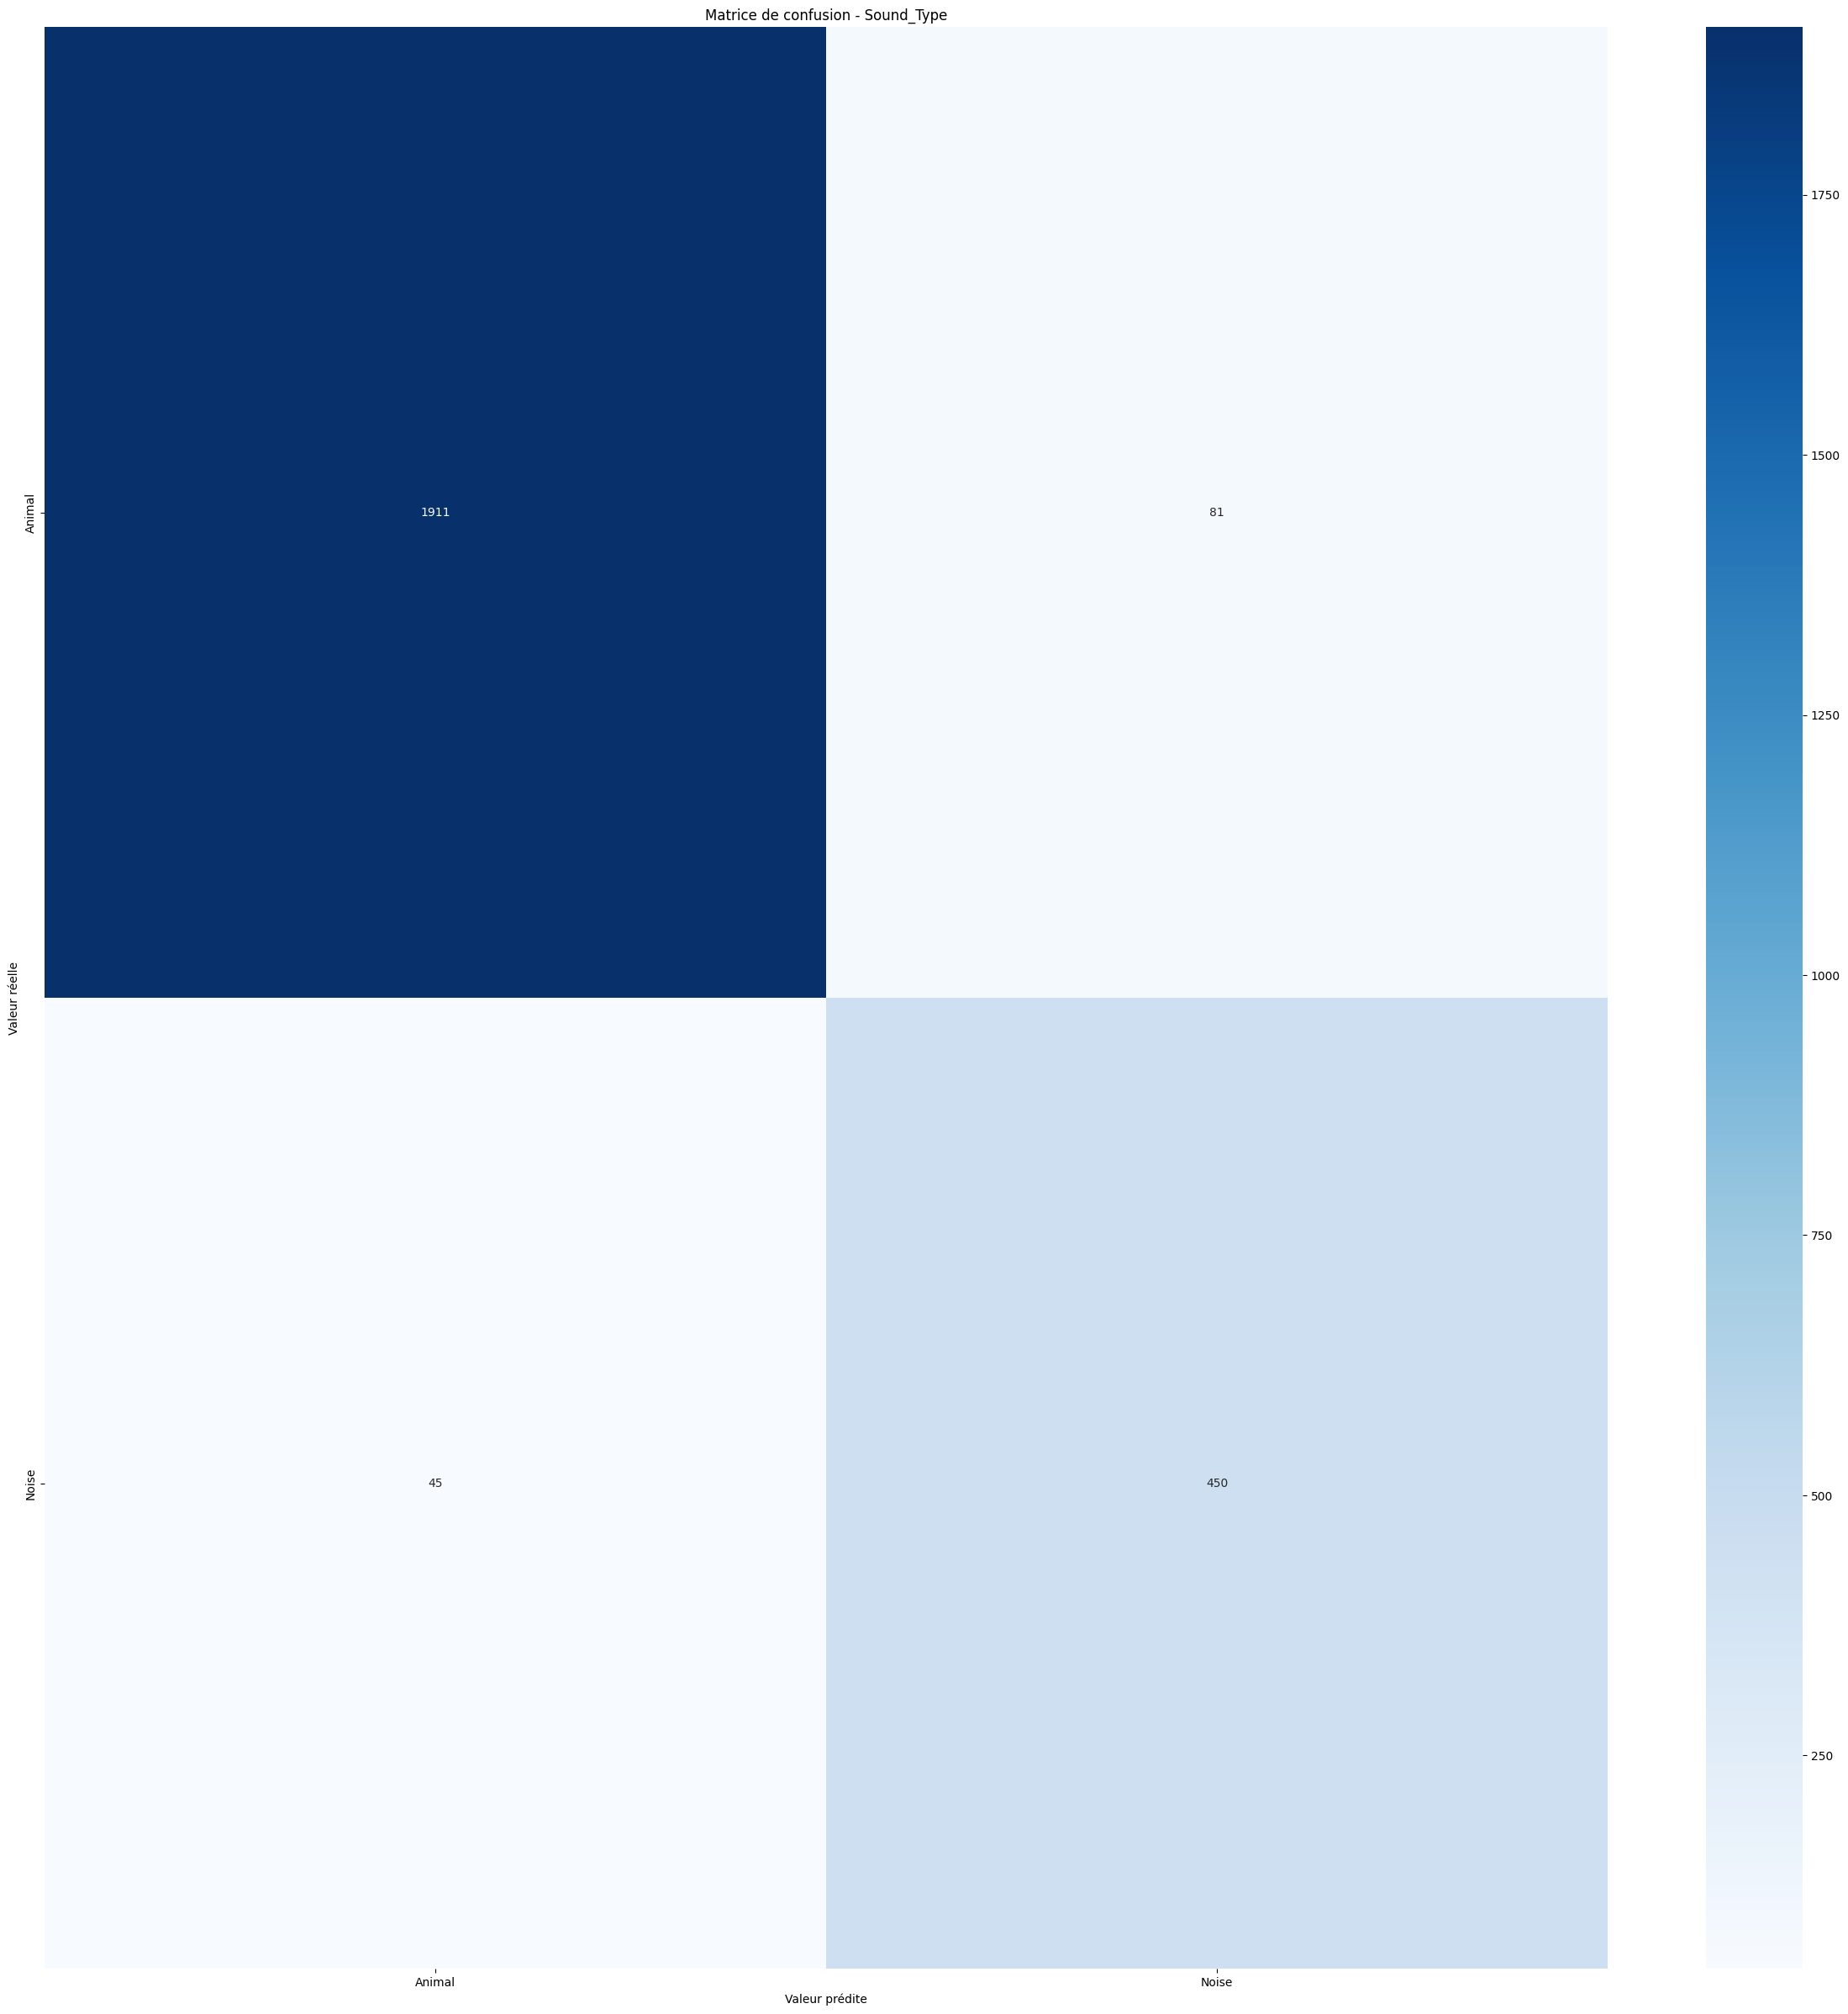

In [11]:
rf_classifier_soundtype = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier_soundtype.fit(X_train, y_train_soundtype)

predictions_soundtype = rf_classifier_soundtype.predict(X_test)

# Évaluation LightGBM
print("Évaluation LightGBM :")
print("Accuracy sur l'ensemble de validation:", accuracy_score(y_test_soundtype, predictions_soundtype))
print(classification_report(y_test_soundtype, predictions_soundtype))

# matrice de confusion
cm = confusion_matrix(y_test_soundtype, predictions_soundtype)
y_test_inversed = label_encoder_soundtype.inverse_transform(y_test_soundtype)

unique_labels = np.unique(y_test_inversed)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion - Sound_Type')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()

Évaluation LightGBM :
Accuracy sur l'ensemble de validation: 0.9498922413793104
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        86
           1       0.72      0.40      0.51       106
           2       0.87      0.59      0.70        22
           3       0.96      0.99      0.98      1642

    accuracy                           0.95      1856
   macro avg       0.86      0.73      0.78      1856
weighted avg       0.94      0.95      0.94      1856



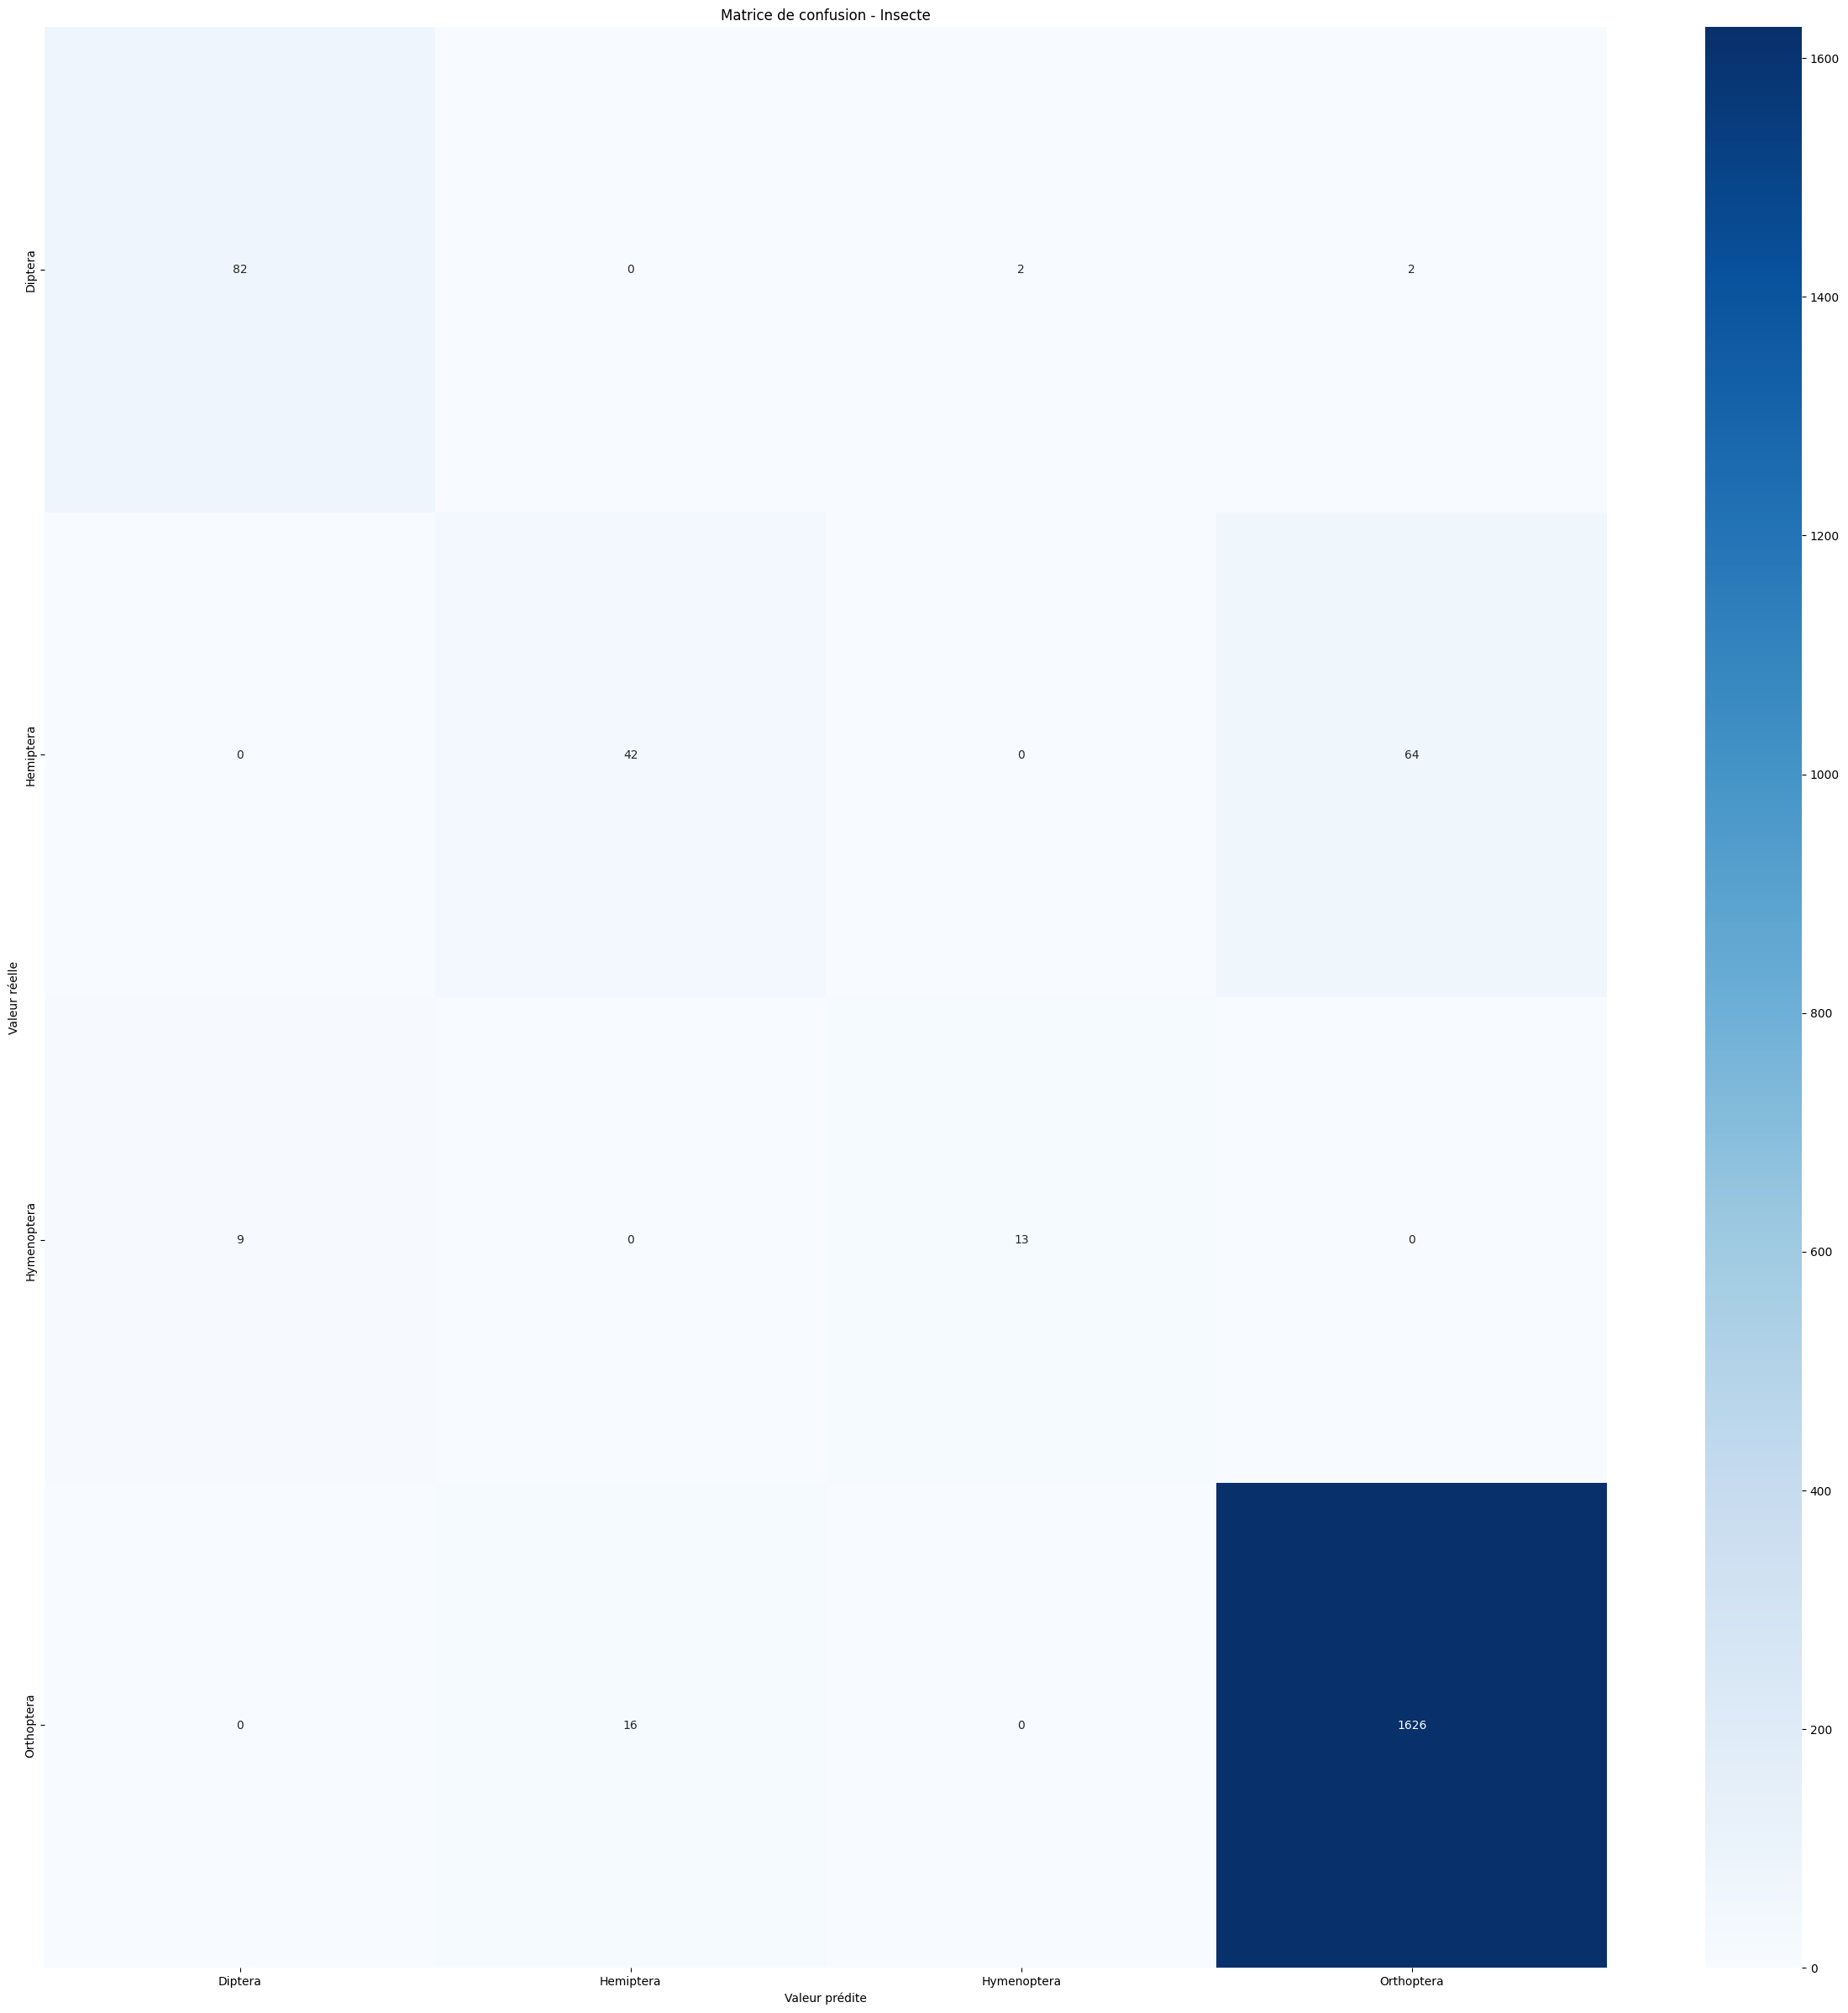

In [12]:
#### Faire avec que les 4 catégories (Ortho, ... voir doc)
rf_classifier_order = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier_order.fit(X_train_order, y_train_order)

predictions_order = rf_classifier_order.predict(X_test_order)

# Évaluation LightGBM
print("Évaluation LightGBM :")
print("Accuracy sur l'ensemble de validation:", accuracy_score(y_test_order, predictions_order))
print(classification_report(y_test_order, predictions_order))

# matrice de confusion
cm = confusion_matrix(y_test_order, predictions_order)
y_test_inversed = label_encoder_order.inverse_transform(y_test_order)

unique_labels = np.unique(y_test_inversed)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion - Insecte')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()

In [ ]:
## Metric actif/passif 